In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from scipy.stats import genpareto
from datetime import datetime

In [2]:
# Get S&P500 data

data = web.DataReader("^SPX", "stooq", datetime(2021, 1, 1), datetime(2024, 12, 31))
data = data.sort_index()

# Convert S&P data to array

data_array = np.asarray(data)

# Select only closing values

closing_vals = data_array[:, 3]
dates = np.arange(0, np.size(closing_vals))

In [3]:
# Transform closing values to stationary ones using log of sucessive returns

stationary_closing_vals = np.array([])

for i in range(1, np.size(closing_vals)):
    log_diff = np.log(closing_vals[i]) - np.log(closing_vals[i-1])
    stationary_closing_vals = np.append(stationary_closing_vals, log_diff)

date_stationary = np.arange(0, np.size(stationary_closing_vals))

# Select first 1000 entries

stationary_closing_vals = stationary_closing_vals[:1000]

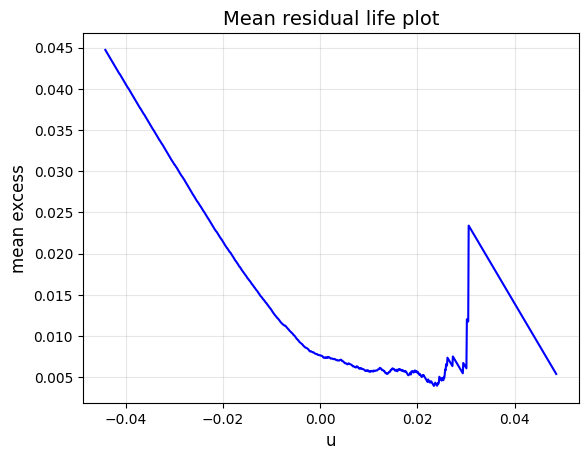

In [4]:
# Create a mean residual life plot to determine threshhold

cut_off = 0.9
threshholds = np.linspace(np.min(stationary_closing_vals), np.max(stationary_closing_vals) * cut_off, 1000)

mean_excess = []

for u in threshholds:
    exceed = stationary_closing_vals[stationary_closing_vals > u]
    if np.size(exceed) > 0:
        mean_excess.append(np.mean(exceed - u))

mean_excess = np.array(mean_excess)

plt.plot(threshholds, mean_excess, color='blue')
plt.grid(True, alpha=0.3)
plt.xlabel('u', fontsize=12)
plt.ylabel('mean excess', fontsize=12)
plt.title('Mean residual life plot', fontsize=14)
plt.show()

In [11]:
# Choose 95-th percentile as threshhold and compute exceedences

threshhold = np.percentile(stationary_closing_vals, 95)
exceedences = stationary_closing_vals[stationary_closing_vals > threshhold] - threshhold

print(threshhold)

# Perform a scaling by 100, i.e X -> 100X

exceedences = 100 * exceedences

0.016505054467781555


In [6]:
# MLE estimates

ξ, μ, σ = genpareto.fit(exceedences)
print(f'MLE estimates are: μ = {np.round(μ, 3)}, σ = {np.round(σ,3)}, ξ = {np.round(ξ,3)}')

MLE estimates are: μ = 0.02, σ = 0.57, ξ = 0.012


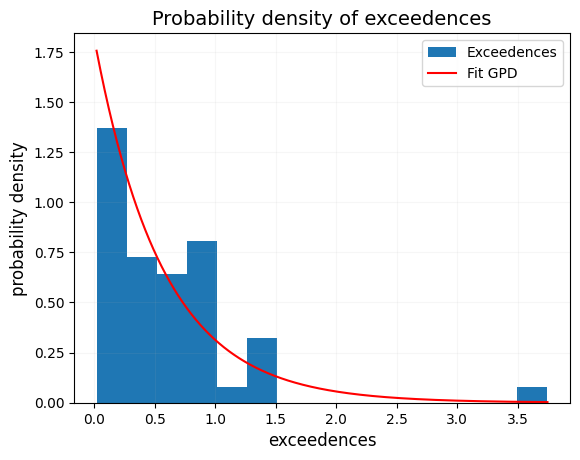

In [13]:
# Plotting of MLE estimates

x = np.linspace(np.min(exceedences), np.max(exceedences), 1000)

pdf = genpareto.pdf(x, ξ, loc=μ, scale=σ)

plt.hist(exceedences, bins=15, density=True, label='Exceedences')
plt.plot(x, pdf, color='red', label='Fit GPD')
plt.grid(True, alpha=0.1)
plt.legend(loc='upper right')
plt.title('Probability density of exceedences', fontsize=14)
plt.ylabel('probability density', fontsize=12)
plt.xlabel('exceedences', fontsize=12)
plt.show()

We have that
\begin{equation}
    VaR = u + \frac{\sigma}{\xi}\left(\left(\frac{\xi_u}{1-\alpha} \right)^\xi - 1\right),
\end{equation}

where $u$ is the threshhold, $\sigma$ the scale parameter, $\xi$ the shape parameter, $\xi_u$ the estimed probability of exceeding $u$ and $\alpha$ the confidence level. The expression above assumes that $\xi \neq 0$. Furhtermore, is the Expected shortfall given by

\begin{equation}
    ES = \frac{1}{1-\xi}(VaR + \sigma - \xi u),
\end{equation}

for $\xi < 1$.  

In [27]:
# Determining VaR

def VaR_excess(sigma, xi, xi_u, alpha):
    return sigma/xi * ((xi_u/(1-alpha))**xi - 1)

xi_u = np.size(exceedences)/np.size(stationary_closing_vals)
alpha = 0.95
u_actual = np.percentile(stationary_closing_vals, 95)

VaR = u_actual + VaR_excess(σ, ξ, xi_u, alpha)

In [28]:
# Determining Expected Shortfall

def ES(var, sigma, xi, u):
    return 1/(1-xi) * (var + sigma - xi * u)

expected_shortfall = ES(VaR, σ, ξ, u_actual)

In [30]:
investment = 10e6
VaR_amount, ES_amount = investment * VaR, investment * expected_shortfall
print(f'VaR amount: {np.round(VaR_amount, 1)}\n')
print(f'ES amount: {np.round(ES_amount, 1)}')

VaR amount: 165050.5

ES amount: 5929077.1
